In [ ]:
#IMPORTS

import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
# List of NIFTY 50 stocks (as of 2023)
NIFTY50_SYMBOLS = [
    "ADANIENT.NS", "ADANIPORTS.NS", "ASIANPAINT.NS", "AXISBANK.NS", "BAJAJ-AUTO.NS",
    "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS", "BRITANNIA.NS",
    "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS", "EICHERMOT.NS",
    "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS", "HEROMOTOCO.NS",
    "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "ITC.NS", "INDUSINDBK.NS",
    "INFY.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS",
    "MARUTI.NS", "NESTLEIND.NS", "NTPC.NS", "ONGC.NS", "POWERGRID.NS",
    "RELIANCE.NS", "SBIN.NS", "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS",
    "TATAMOTORS.NS", "TATASTEEL.NS", "TECHM.NS", "TITAN.NS", "ULTRACEMCO.NS",
    "UPL.NS", "WIPRO.NS"
]

In [ ]:
def get_historical_data(symbols, start_date, end_date):
    data = yf.download(symbols, start=start_date, end=end_date)
    return data

def get_shares_outstanding(symbols):
    shares_outstanding = {}
    for symbol in symbols:
        stock = yf.Ticker(symbol)
        try:
            shares = stock.info['sharesOutstanding']
            shares_outstanding[symbol] = shares
        except:
            shares_outstanding[symbol] = np.nan
    return pd.Series(shares_outstanding)

def calculate_market_caps(prices, shares_outstanding):
    return prices.multiply(shares_outstanding, axis=1)

def fetch_market_caps(symbols, start_date, end_date):
    # Get historical price data
    historical_data = get_historical_data(symbols, start_date, end_date)

    # Get shares outstanding
    shares_outstanding = get_shares_outstanding(symbols)

    # Calculate market caps
    market_caps = calculate_market_caps(historical_data['Close'], shares_outstanding)

    return market_caps

def calculate_log_returns(prices):
    return np.log(prices / prices.shift(1))

def calculate_shares_outstanding(market_cap, price):
    return market_cap / price

def calculate_turnover_rate(volume, shares_outstanding):
    return volume / shares_outstanding

def calculate_volatility(returns, window=20):
    return returns.rolling(window=window).std()

def calculate_momentum_p1(mass, velocity, lookback):
    return (mass * velocity).rolling(window=lookback).sum()

def calculate_momentum_p2(mass, velocity, lookback):
    numerator = (mass * velocity).rolling(window=lookback).sum()
    denominator = mass.rolling(window=lookback).sum()
    return numerator / denominator

def calculate_momentum_p3(returns, volatility, lookback):
    return returns.rolling(window=lookback).mean() / volatility



def calculate_portfolio_returns(returns, portfolios, long_group, short_group):
    long_returns = returns[portfolios == long_group].mean()
    short_returns = returns[portfolios == short_group].mean()
    return long_returns - short_returns  # Market neutral return

def get_first_trading_days(data):
    """Selects the first valid trading day of each month."""
    return data.groupby([data.index.year, data.index.month]).first()

def create_portfolios(momentum, num_groups=10):
    """
    Create portfolios based on momentum rankings, handling NaN and identical values.

    Parameters:
    momentum (pd.DataFrame): A DataFrame with stocks as columns and dates as index.
    num_groups (int): Number of portfolios to create.

    Returns:
    pd.DataFrame: A DataFrame with the same shape as momentum, containing portfolio assignments.
    """
    def rank_and_group(row):
        if row.isnull().all() or row.nunique() == 1:
            return pd.Series(np.nan, index=row.index)
        else:
            try:
                return pd.qcut(row.rank(method='first'), num_groups, labels=False, duplicates='drop') + 1
            except ValueError:
                # If we still get a ValueError, return NaN for this row
                return pd.Series(np.nan, index=row.index)

    return momentum.apply(rank_and_group, axis=1)

def run_momentum_strategy(start_date, end_date, lookback_months, holding_months, momentum_type='p1', initial_capital=1000000):
    print(f"Strategy parameters: Start: {start_date}, End: {end_date}, Lookback: {lookback_months}, Holding: {holding_months}")

    # Download price and volume data
    data = yf.download(NIFTY50_SYMBOLS, start=start_date, end=end_date)
    #print(f"Data shape: {data.shape}")
    #print(f"Date range: {data.index[0]} to {data.index[-1]}")

    # Ensure the index is the date
    data.index = pd.to_datetime(data.index)

    # Select the first valid trading day of each month
    monthly_data = get_first_trading_days(data)
    #print(f"Monthly data shape: {monthly_data.shape}")

    # Fetch market caps for all symbols
    market_caps = fetch_market_caps(NIFTY50_SYMBOLS, start_date, end_date)
    #print(f"Market caps shape: {market_caps.shape}")

    # Calculate monthly log returns
    log_returns = calculate_log_returns(monthly_data['Adj Close'])
    #print(f"Log returns shape: {log_returns.shape}")
    #print(f"Log returns summary:\n{log_returns.describe()}")

    # Calculate shares outstanding (use the most recent data point)
    shares_outstanding = get_shares_outstanding(NIFTY50_SYMBOLS)
    #print(f"Shares outstanding:\n{shares_outstanding}")

    # Calculate monthly turnover rate
    turnover_rate = calculate_turnover_rate(monthly_data['Volume'], shares_outstanding)
    #print(f"Turnover rate summary:\n{turnover_rate.describe()}")

    # Calculate monthly volatility
    volatility = calculate_volatility(log_returns)
    #print(f"Volatility summary:\n{volatility.describe()}")

    # Calculate momentum based on the specified type
    if momentum_type == 'p1':
        momentum = calculate_momentum_p1(turnover_rate, log_returns, lookback_months)
    elif momentum_type == 'p2':
        momentum = calculate_momentum_p2(turnover_rate, log_returns, lookback_months)
    elif momentum_type == 'p3':
        momentum = calculate_momentum_p3(log_returns, volatility, lookback_months)
    else:
        raise ValueError("Invalid momentum type. Choose 'p1', 'p2', or 'p3'.")

    # Debugging: Print momentum statistics
    # print(f"Momentum type: {momentum_type}")
    # print(f"Momentum statistics:\n{momentum.describe()}")
    # print(f"Number of NaN values: {momentum.isna().sum().sum()}")

    #print(f"Momentum summary:\n{momentum.describe()}")
    # Create portfolios
    portfolios = create_portfolios(momentum)
    #print(f"Portfolios shape: {portfolios.shape}")
    # print(f"Portfolio statistics:\n{portfolios.describe()}")
    # print(f"Number of NaN values in portfolios: {portfolios.isna().sum().sum()}")

    # Initialize DataFrame to store strategy returns
    strategy_returns = pd.DataFrame(index=log_returns.index, columns=['Returns'])

    # Iterate through the data with overlapping portfolios (using the holding period K)
    for i in range(holding_months, len(log_returns)):
        # Combine the returns from all active portfolios within the holding period window
        combined_portfolio_returns = pd.Series(0, index=log_returns.columns)

        for j in range(holding_months):
            if i - j < 0:
                break

            # Construct portfolios at time `i-j` and calculate returns over the holding period
            current_portfolios = portfolios.iloc[i - j]
            period_returns = log_returns.iloc[i]

            # Skip periods where we couldn't create portfolios
            if current_portfolios.isnull().all():
                continue

            # Traditional strategy: Long winners (portfolio 10), short losers (portfolio 1)
            long_returns = period_returns[current_portfolios == 10].mean()
            short_returns = period_returns[current_portfolios == 1].mean()
            period_strategy_returns = long_returns - short_returns

            # Sum the returns from all active overlapping portfolios
            combined_portfolio_returns += period_strategy_returns

        # Average the returns of overlapping portfolios
        combined_portfolio_returns /= holding_months

        # Assign these returns to the strategy returns DataFrame
        strategy_returns.iloc[i] = combined_portfolio_returns.mean()

    #print(f"Strategy returns summary:\n{strategy_returns.describe()}")

    # Calculate cumulative returns
    cumulative_returns = (1 + strategy_returns).cumprod()
    #print(f"Cumulative returns:\nStart: {cumulative_returns.iloc[0].values[0]}\nEnd: {cumulative_returns.iloc[-1].values[0]}")

    # Calculate portfolio value
    portfolio_value = initial_capital * cumulative_returns
    #print(f"Portfolio value:\nStart: {portfolio_value.iloc[0].values[0]}\nEnd: {portfolio_value.iloc[-1].values[0]}")

    columns = ['Date', 'Position', 'Symbol', 'Momentum Score']
    top_bottom_stocks = pd.DataFrame(columns=columns)

    # Iterate through each date in the momentum DataFrame
    for date, row in momentum.iterrows():
        # Sort stocks by momentum score
        sorted_stocks = row.sort_values(ascending=False)

        # Get top 5 and bottom 5 stocks
        top_5 = sorted_stocks.head(5)
        bottom_5 = sorted_stocks.tail(5)

        # Create a list to store new rows
        new_rows = []

        # Add top 5 to the list
        for symbol, score in top_5.items():
            new_rows.append({
                'Date': date,
                'Position': 'Long',
                'Symbol': symbol,
                'Momentum Score': score
            })

        # Add bottom 5 to the list
        for symbol, score in bottom_5.items():
            new_rows.append({
                'Date': date,
                'Position': 'Short',
                'Symbol': symbol,
                'Momentum Score': score
            })

        # Concatenate the new rows to the existing DataFrame
        top_bottom_stocks = pd.concat([top_bottom_stocks, pd.DataFrame(new_rows)], ignore_index=True)

    return strategy_returns, cumulative_returns, portfolio_value, portfolios, top_bottom_stocks


In [ ]:
start_date = '2019-01-01'
end_date = '2023-12-31'
lookback_months = 3
holding_months = 4
initial_capital = 1000000

strategy_returns, cumulative_returns, portfolio_value, portfolios, top_bottom_stocks = run_momentum_strategy(
    start_date, end_date, lookback_months, holding_months, momentum_type='p2', initial_capital=initial_capital
)



Strategy parameters: Start: 2019-01-01, End: 2023-12-31, Lookback: 3, Holding: 4


[*********************100%***********************]  47 of 47 completed
[*********************100%***********************]  47 of 47 completed
<ipython-input-2-ac5bf70b6d87>:224: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_bottom_stocks = pd.concat([top_bottom_stocks, pd.DataFrame(new_rows)], ignore_index=True)


In [ ]:

def calculate_performance_metrics(strategy_returns, portfolio_value, initial_capital, holding_months, risk_free_rate=0.0):
    # Calculate performance metrics
    total_years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 252
    total_return = (portfolio_value.iloc[-1, 0] - initial_capital) / initial_capital
    annualized_return = (1 + total_return) ** (1 / total_years) - 1  # 252 trading days
    sharpe_ratio = np.sqrt(252) * (strategy_returns.mean().iloc[0] - risk_free_rate) / strategy_returns.std(axis=0).iloc[0]  # Annualized Sharpe Ratio

    # Sortino ratio: Annualized return divided by downside deviation
    downside_returns = strategy_returns[strategy_returns < 0]  # Only consider negative returns
    downside_deviation = downside_returns.std(axis=0) * np.sqrt(252)  # Annualized downside deviation

    # Handle the case where downside_deviation is not zero
    if not downside_returns.empty and downside_deviation.any():
        sortino_ratio = np.sqrt(252) * (strategy_returns.mean().iloc[0] - risk_free_rate) / downside_deviation.iloc[0]
    else:
        sortino_ratio = np.nan

    # Max Drawdown
    max_drawdown = (portfolio_value / portfolio_value.cummax() - 1).min().iloc[0]

    # Calculate trade frequency
    trade_frequency = 252 / (holding_months * 21)  # Assuming 21 trading days per month

    # Calculate volatility (annualized)
    volatility = strategy_returns.std(axis=0).iloc[0] * np.sqrt(252)

    # Calculate rolling volatility (volatility over time using a 1-month rolling window)
    rolling_volatility = strategy_returns.rolling(window=5).std() * np.sqrt(252)

    # Print results
    print(f"Total Return in the entire trading period: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    print(f"Trade Frequency: {trade_frequency:.2f} trades per year")
    print(f"Annualized Volatility: {volatility:.2%}")

    return {
        "total_return": total_return,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "max_drawdown": max_drawdown,
        "trade_frequency": trade_frequency,
        "volatility": volatility,
        "rolling_volatility": rolling_volatility
    }
start_date = '2019-01-01'
end_date = '2023-12-31'
lookback_months = 3
holding_months = 4
initial_capital = 1000000
metrics = calculate_performance_metrics(strategy_returns, portfolio_value, initial_capital, holding_months)


Total Return in the entire trading period: 680.20%
Annualized Return: 32.80%
Sharpe Ratio: 11.14
Sortino Ratio: 1.25
Maximum Drawdown: -10.93%
Trade Frequency: 3.00 trades per year
Annualized Volatility: 87.64%


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# Define performance metric calculation function
def calculate_performance_metrics(returns, portfolio_value, initial_capital, holding_months, risk_free_rate=0.0):
    total_years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 252
    total_return = (portfolio_value.iloc[-1, 0] - initial_capital) / initial_capital
    annualized_return = (1 + total_return) ** (1 / total_years) - 1  # 252 trading days
    sharpe_ratio = np.sqrt(252) * (returns.mean().iloc[0] - risk_free_rate) / returns.std(axis=0).iloc[0]  # Annualized Sharpe Ratio

    downside_returns = returns[returns < 0]
    downside_deviation = downside_returns.std(axis=0) * np.sqrt(252)

    if not downside_returns.empty and downside_deviation.any():
        sortino_ratio = np.sqrt(252) * (returns.mean().iloc[0] - risk_free_rate) / downside_deviation.iloc[0]
    else:
        sortino_ratio = np.nan

    max_drawdown = (portfolio_value / portfolio_value.cummax() - 1).min().iloc[0]


    print(f"Total Return in the entire trading period: {total_return:.2%}")
    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")


    return {
        "total_return": total_return,
        "annualized_return": annualized_return,
        "sharpe_ratio": sharpe_ratio,
        "sortino_ratio": sortino_ratio,
        "max_drawdown": max_drawdown
    }

# Download historical data for NIFTY 50
nifty50_data = yf.download('^NSEI', start=start_date, end=end_date)


# Calculate NIFTY 50 returns
nifty50_data['Returns'] = nifty50_data['Adj Close'].pct_change().dropna()



# Simulate the portfolio value for NIFTY 50 assuming buy and hold with initial capital
nifty50_data['Portfolio Value'] = (1 + nifty50_data['Returns']).cumprod() * initial_capital


# Reshape portfolio_value to match the structure used in the calculate_performance_metrics function
nifty50_portfolio_value = nifty50_data[['Portfolio Value']]



# Calculate performance metrics for NIFTY 50
if not nifty50_portfolio_value.empty:  # Check if data is not empty
    nifty50_metrics = calculate_performance_metrics(nifty50_data[['Returns']], nifty50_portfolio_value, initial_capital, holding_months)
else:
    print("Portfolio value for NIFTY 50 is empty.")


[*********************100%***********************]  1 of 1 completed

Total Return in the entire trading period: 101.36%
Annualized Return: 10.15%
Sharpe Ratio: 0.85
Sortino Ratio: 0.06
Maximum Drawdown: -38.44%


In [ ]:
metrics["rolling_volatility"]

Returns
Date Date          
2019 1          NaN
     2          NaN
     3          NaN
     4          NaN
     5          NaN
     6          NaN
     7          NaN
     8          NaN
     9     0.741170
     10    0.729389
     11    1.015576
     12    1.021901
2020 1     0.990008
     2     0.811073
     3     0.682404
     4     1.725676
     5     1.611098
     6     1.559808
     7     2.120873
     8     2.156891
     9     1.284137
     10    1.482801
     11    1.483469
     12    0.610547
2021 1     0.614813
     2     0.526226
     3     0.875189
     4     0.906625
     5     0.917132
     6     0.981627
     7     1.121846
     8     0.574307
     9     0.668445
     10    0.683404
     11    0.733107
     12    0.742677
2022 1     0.641888
     2     0.628581
     3     0.524545
     4     0.535771
     5     0.441979
     6     0.373933
     7     0.645256
     8     0.636314
     9     0.580980
     10    0.651842
     11    0.651630
     12    0.423232
2023 1     0.456108
     2     0.552500
     3     0.581215
     4     0.579608
     5     0.452810
     6     0.455777
     7     0.327922
     8     0.352683
     9     0.350007
     10    0.329198
     11    0.208245
     12    0.224403

<Figure size 1200x1200 with 0 Axes>

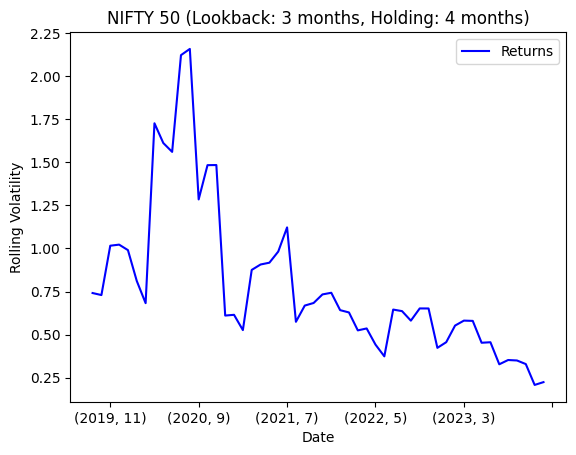

In [ ]:

plt.figure(figsize=(12, 12))

# Plot the portfolio value for NIFTY 50
metrics["rolling_volatility"].plot(label='Rolling Volatility', color='blue')

# Set plot title, labels, and legend
plt.title(f'NIFTY 50 (Lookback: {lookback_months} months, Holding: {holding_months} months)')
plt.xlabel('Date')
plt.ylabel('Rolling Volatility')
plt.legend()

# Display the plot
plt.show()


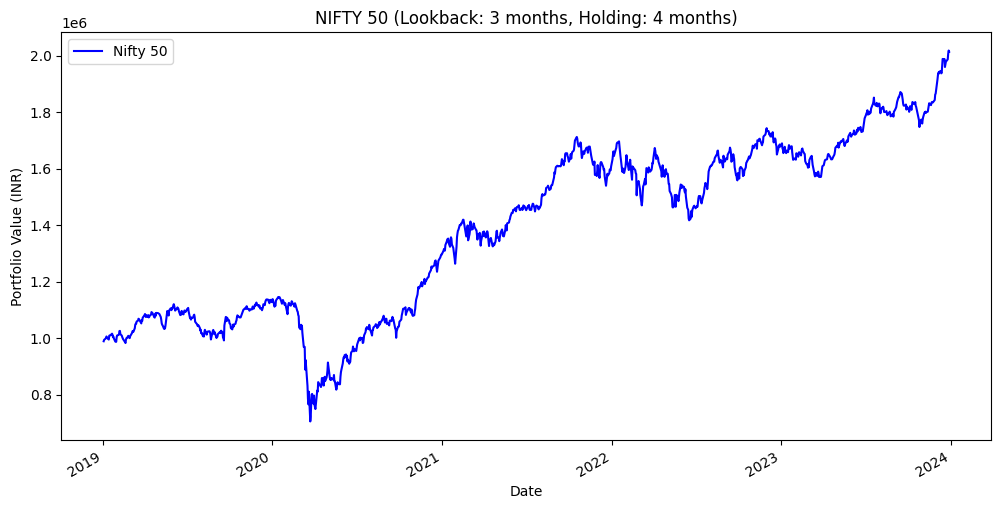

In [ ]:
plt.figure(figsize=(12, 6))

# Plot the portfolio value for NIFTY 50
nifty50_data['Portfolio Value'].plot(label='Nifty 50', color='blue')

# Set plot title, labels, and legend
plt.title(f'NIFTY 50 (Lookback: {lookback_months} months, Holding: {holding_months} months)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()

# Display the plot
plt.show()


In [ ]:
top_bottom_stocks.tail(20)

,Date,Position,Symbol,Momentum Score
580,"(2023, 11)",Long,COALINDIA.NS,0.072990
581,"(2023, 11)",Long,HCLTECH.NS,0.037524
582,"(2023, 11)",Long,BAJAJ-AUTO.NS,0.031381
583,"(2023, 11)",Long,MARUTI.NS,0.030688
584,"(2023, 11)",Long,NTPC.NS,0.030326
585,"(2023, 11)",Short,ITC.NS,-0.031087
586,"(2023, 11)",Short,JSWSTEEL.NS,-0.035018
587,"(2023, 11)",Short,HDFCBANK.NS,-0.041236
588,"(2023, 11)",Short,ASIANPAINT.NS,-0.044862
589,"(2023, 11)",Short,UPL.NS,-0.061515


In [ ]:
portfolio_value

Returns
Date Date                
2019 1                NaN
     2                NaN
     3                NaN
     4                NaN
     5      1014701.93891
     6     1055612.724834
     7     1125655.227113
     8     1110892.341678
     9     1230806.087934
     10    1330318.106612
     11    1275695.208656
     12      1272195.6467
2020 1      1274913.84562
     2     1359955.914369
     3     1425378.039192
     4     1799419.031079
     5     1890884.459315
     6     1926533.200526
     7     1715876.451428
     8     1907190.591977
     9     1966473.078876
     10    2210492.760866
     11     2344775.75879
     12    2576576.596782
2021 1     2690845.739141
     2     2846273.196382
     3     3358824.286212
     4     3517619.046798
     5     3717518.300803
     6      3796638.79671
     7     3787669.271235
     8     4139796.864028
     9     4113842.828816
     10    4072618.313904
     11    4300895.891885
     12    4612586.843029
2022 1     4566710.634282
     2     4818244.482773
     3      4922412.13182
     4     4964670.164372
     5     5219612.888014
     6     5246302.397018
     7     5786286.640544
     8     5949991.779169
     9     6160502.587325
     10    6163280.009709
     11    6195257.350439
     12    5995569.899975
2023 1     6221101.623081
     2     6578612.161903
     3     6490961.776964
     4     6546425.628379
     5     6562214.415145
     6     6488963.732177
     7      6735709.38227
     8     6996145.202926
     9     7074222.884417
     10     7204973.12267
     11    7480206.235432
     12    7801981.731086